In [1]:
import os, sys
import dill
import pandas as pd
import numpy as np
import umap 

import faiss

import matplotlib.pyplot as plt
from matplotlib.patches import Patch


## Mapping embedding data to UMAP coordinates

In [2]:
with open("../private/fitted_UMAP_model.pkl", "rb") as f:
    trans_full = dill.load(f)

In [3]:
example_data = pd.read_csv("../model/pretrained_model_with_dae/test_imputed_embeddings.csv",
                         sep=",")
example_data = example_data.iloc[:, 1:129]

In [4]:
example_data_UMAP = trans_full.transform(example_data)
# example_data_UMAP

In [5]:
devel_base_UMAP = pd.read_csv("../private/UKB_devel_baseline_UMAP.csv",
                             sep=",")

In [6]:
merged_UMAP = np.concatenate([devel_base_UMAP.iloc[:,1:3].to_numpy(), example_data_UMAP], axis=0)
label_UMAP = ["devel_base"] * devel_base_UMAP.shape[0] + ["test"] * example_data_UMAP.shape[0]
color_UMAP = ["black"] * devel_base_UMAP.shape[0] + ["red"] * example_data_UMAP.shape[0]
size_UMAP = [1] * devel_base_UMAP.shape[0] + [10] * example_data_UMAP.shape[0]

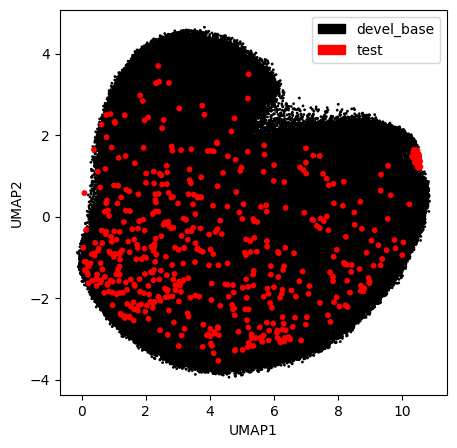

In [7]:


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
ax.scatter(merged_UMAP[:,0], merged_UMAP[:,1], label=label_UMAP, color=color_UMAP, s=size_UMAP)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")


legend_elements = [Patch(facecolor='black', edgecolor='black', label='devel_base'), 
                   Patch(facecolor='red', edgecolor='red', label='test')]

ax.legend(handles=legend_elements, loc='upper right')
# ax.legend(loc='upper right')


plt.show()

## Assigning embedding data to CVD_DT clusters

In [8]:
import faiss
faiss.__version__

'1.8.0'

In [10]:
embed_data = pd.read_csv("../private/devel_imputed_embeddings_full.csv")
embed_data.shape

(340507, 129)

In [11]:
ukb_baseline_cluster_df = pd.read_csv("../private/base_devel_cluster.tsv", sep="\t")

In [12]:
## Faiss K-NN class from https://gist.github.com/j-adamczyk/74ee808ffd53cd8545a49f185a908584

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [13]:
fknn = FaissKNeighbors(k=200)

In [14]:
fknn.fit(embed_data.iloc[:, 1:], ukb_baseline_cluster_df['louvain'].to_numpy())

In [15]:
example_prdicted_clusters = fknn.predict(example_data)
example_prdicted_clusters

array([8, 0, 5, 0, 7, 3, 0, 0, 0, 0, 1, 0, 3, 1, 4, 4, 1, 0, 0, 5, 3, 0,
       0, 2, 7, 4, 0, 1, 2, 0, 0, 0, 0, 4, 2, 0, 4, 0, 1, 2, 2, 0, 4, 0,
       4, 1, 0, 0, 1, 0, 0, 4, 2, 0, 0, 3, 0, 0, 4, 0, 2, 4, 0, 7, 0, 5,
       0, 0, 4, 7, 0, 1, 4, 2, 4, 2, 0, 0, 4, 0, 0, 1, 0, 7, 0, 4, 0, 1,
       0, 5, 0, 0, 2, 1, 3, 1, 0, 7, 0, 2, 0, 2, 1, 2, 4, 0, 0, 4, 1, 4,
       2, 1, 1, 0, 0, 0, 2, 2, 4, 4, 7, 0, 2, 1, 0, 0, 0, 4, 4, 0, 0, 1,
       0, 2, 4, 0, 7, 3, 7, 0, 0, 1, 0, 7, 5, 1, 4, 5, 0, 0, 3, 0, 1, 3,
       2, 4, 1, 0, 0, 2, 0, 2, 0, 5, 7, 0, 0, 4, 4, 5, 1, 7, 1, 0, 0, 7,
       0, 3, 4, 4, 0, 0, 5, 7, 1, 0, 7, 2, 2, 0, 2, 7, 0, 4, 0, 0, 0, 2,
       1, 0, 0, 0, 4, 4, 0, 0, 5, 1, 0, 1, 0, 0, 0, 5, 0, 0, 4, 1, 0, 0,
       1, 0, 4, 0, 0, 1, 2, 1, 0, 4, 0, 5, 0, 7, 4, 4, 5, 2, 1, 0, 0, 3,
       4, 2, 0, 0, 4, 1, 4, 4, 4, 0, 0, 0, 2, 0, 7, 0, 4, 0, 4, 0, 0, 1,
       2, 1, 4, 1, 2, 1, 4, 5, 3, 7, 1, 2, 0, 0, 1, 0, 2, 1, 0, 4, 4, 0,
       4, 5, 1, 0, 0, 4, 4, 1, 1, 0, 0, 6, 1, 0, 0,

In [16]:
merged_UMAP = np.concatenate([devel_base_UMAP.iloc[:,1:3].to_numpy(), example_data_UMAP], axis=0)
label_UMAP = ["devel_base"] * devel_base_UMAP.shape[0] + ["test"] * example_data_UMAP.shape[0]
color_UMAP = ["black"] * devel_base_UMAP.shape[0] + ["red"] * example_data_UMAP.shape[0]


cl_color = ['#1f77b4', # CLUSTER 0
              '#e377c2', # CLUSTER 1
              '#d62728', # CLUSTER 2
              '#17becf', # CLUSTER 3
              '#aa40fc', # CLUSTER 4
              '#8c564b', # CLUSTER 5
              '#279e68', # CLUSTER 6
              '#b5bd61', # CLUSTER 7
              '#aec7e8', # CLUSTER 8
              '#ff7f0e'] # CLUSTER 9
color_cluster_UMAP = [cl_color[i] for i in (list(ukb_baseline_cluster_df['louvain']) + list(example_prdicted_clusters))]
size_UMAP = [.2] * devel_base_UMAP.shape[0] + [10] * example_data_UMAP.shape[0]

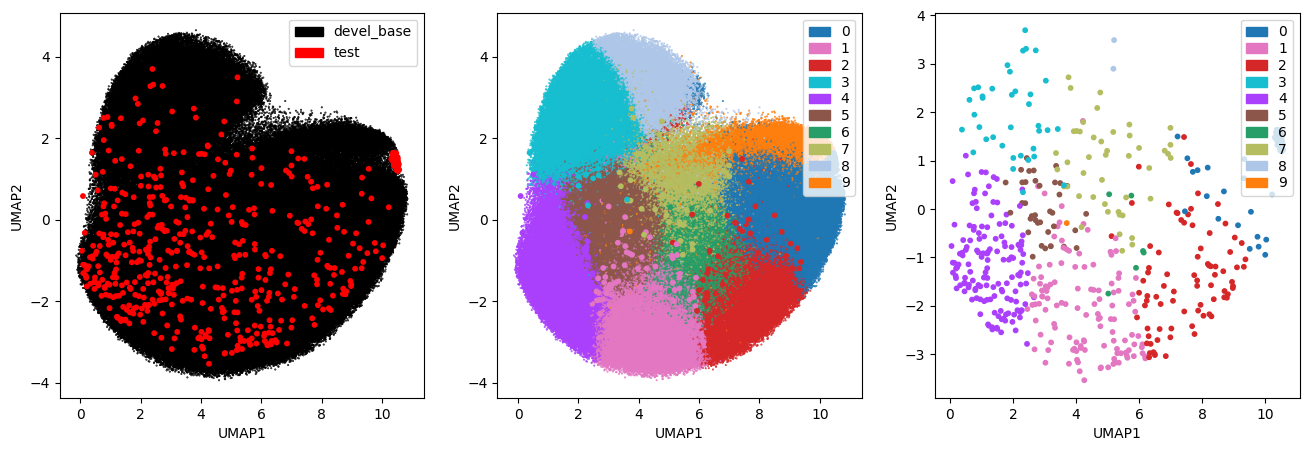

In [17]:


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[16, 5])
ax[0].scatter(merged_UMAP[:,0], merged_UMAP[:,1], label=label_UMAP, color=color_UMAP, s=size_UMAP)
ax[0].set_xlabel("UMAP1")
ax[0].set_ylabel("UMAP2")
legend_elements_ax0 = [Patch(facecolor='black', edgecolor='black', label='devel_base'), 
                   Patch(facecolor='red', edgecolor='red', label='test')]

ax[0].legend(handles=legend_elements_ax0, loc='upper right')

ax[1].scatter(merged_UMAP[:,0], merged_UMAP[:,1], c=color_cluster_UMAP, s=size_UMAP)
ax[1].set_xlabel("UMAP1")
ax[1].set_ylabel("UMAP2")
legend_elements_ax1 = [Patch(facecolor=cl_color[i], 
                            edgecolor=cl_color[i], label=str(i)) for i in range(10)]

ax[1].legend(handles=legend_elements_ax1, loc='upper right', labelspacing=0.2, handlelength=1.5)



ax[2].scatter(example_data_UMAP[:,0], example_data_UMAP[:,1], c=[cl_color[i] for i in list(example_prdicted_clusters)], 
              s=10)
ax[2].set_xlabel("UMAP1")
ax[2].set_ylabel("UMAP2")
legend_elements_ax2 = [Patch(facecolor=cl_color[i], 
                            edgecolor=cl_color[i], label=str(i)) for i in range(10)]

ax[2].legend(handles=legend_elements_ax2, loc='upper right', labelspacing=0.2, handlelength=1.5)

plt.show()